In [2]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64, prange
import numba
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix
from datetime import datetime
from qutip import sigmax, sigmay, sigmaz, jmat
import time
import h5py
from labellines import labelLine, labelLines
from time import sleep
from adjustText import adjust_text
import matplotlib.animation as animation

In [5]:
from spin_reconstruction.constants import *

In [6]:
file = "reconstructed_fine_nb_full.hdf5"
couplings_file = "fine_couplings_nb_full_B_0.hdf5"

title = f"Reconstruction with A parallel.\n Including the W-W zero couplings"


# State reconstruction

In [7]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
            index // (max_distance**2 * site_nb) - center,
            index // (max_distance * site_nb) % max_distance - center,
            index // site_nb % max_distance - center,
            index % site_nb
        )

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return (
                            (
                                (
                                    (vec[0] + center)*max_distance + (vec[1] + center)
                                )*max_distance
                                + (vec[2] + center)
                            )*site_nb
                            + vec[3]
                       
       )


@jit
def compute_dr(i, size, distance):
    center = size // 2
    x = i // (size**2) - center
    y = (i // size) % size - center
    z = i % size - center
    return np.array([x, y, z]) * distance

@jit
def compute_all_dr(data, size, distance):
    rslt = np.empty((*data.shape,3))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            rslt[i, j] = compute_dr(data[i, j], size, distance)
    return rslt



In [8]:
 
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

###  Load data

In [9]:
from measurement_data import data_header, renormalized_data, a_par_data, nb_par_data

### Compute

In [10]:
with (
    h5py.File(file, "r") as g,
    h5py.File(couplings_file, "r") as f
):
    permutation_inv = invert_permutation(g["permutation"][:])
    config = g.attrs["config"]
    print(config)
    max_distance = f.attrs["max_distance"]
    base_sites = np.array([index_to_coord(c, max_distance, site_nb) for c in config])
    base_positions = lattice_x[None,:]*base_sites[:,0][:,None] + lattice_y[None,:] * base_sites[:,1][:,None] + lattice_z[None,:] * base_sites[:,2][:,None] + lattice_s[base_sites[:,3]]
    if "selected_sites" in g.attrs:
        selected_sites = g.attrs["selected_sites"]
    else:
        selected_sites = np.arange(len(base_sites))
    size = g.attrs["size"]
    step = g.attrs["distance"]
    all_displacements_index = g["sites"][:]
    nb_displacements_index = g["nb_sites"][:]
    all_displacements = compute_all_dr(all_displacements_index, size, g.attrs["distance"])
    all_nb_displacements = compute_all_dr(nb_displacements_index[None,:], size, g.attrs["distance"])[0]
    all_errors = g["errors"][:]
    couplings = {
        (i, j): (np.array(f[f"/SEDOR_couplings/{i}_{j}"][:], dtype=np.float64))
            for j in range(len(a_par_data))
            for i in range(len(a_par_data))
            if f"/SEDOR_couplings/{i}_{j}" in f
    }
    a_par = np.array([f[f"A_par_couplings/{i}"][:] for i in range(len(a_par_data))])
    nb_par = np.array([f[f"Nb_par_couplings_full/{i}"][:] for i in range(len(a_par_data))])


[1459 1784 1133 1136 1168 2107 1744 1497 1460]


In [11]:
positions = all_displacements[0][permutation_inv] + base_positions[selected_sites]
nb_displacement = all_nb_displacements[0]
positions, (simplex := np.array([[1.951e+00, 4.906e+00, -7.758e+00],[ -6.802e-01, 4.756e+00, -4.403e+00]])*1e-10)

(array([[-1.2000e-10,  1.1215e-10,  7.9320e-10],
        [ 5.4645e-10,  5.0215e-10,  8.3760e-10],
        [-5.6215e-10, -2.1000e-10,  5.5440e-10],
        [-2.9215e-10, -7.8500e-12,  9.8760e-10],
        [ 7.8500e-12,  5.4645e-10,  2.7000e-10],
        [ 7.4860e-10,  4.4215e-10,  1.0032e-09],
        [ 4.8645e-10, -1.1215e-10,  2.7000e-10],
        [-3.7850e-11,  4.9430e-10,  1.2420e-09],
        [ 1.4215e-10,  2.3215e-10,  1.1076e-09]]),
 array([[ 1.951e-10,  4.906e-10, -7.758e-10],
        [-6.802e-11,  4.756e-10, -4.403e-10]]))

In [12]:
all_displacements[0][permutation_inv]/3.5e-10

array([[-0.34285714, -0.42857143, -0.17142857],
       [-0.68571429,  0.68571429, -0.85714286],
       [-0.85714286, -0.6       ,  0.77142857],
       [-0.08571429, -0.77142857, -0.42857143],
       [ 0.77142857, -0.68571429,  0.77142857],
       [-0.85714286,  0.51428571,  0.42857143],
       [-0.85714286,  0.42857143,  0.77142857],
       [-0.85714286, -0.08571429, -0.51428571],
       [-0.34285714, -0.08571429, -0.08571429]])

# Results overview

### Abundancy

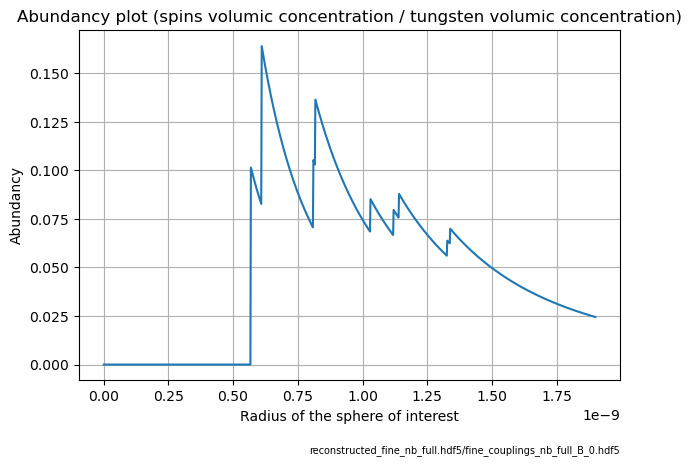

In [13]:
radius = np.max(np.linalg.norm(positions-erbium_position, axis = 1))

full_sites = np.array([index_to_coord(i, max_distance, 4) for i in range(4*max_distance**3)])
full_positions = lattice_x[None,:]*full_sites[:,0][:,None] + lattice_y[None,:] * full_sites[:,1][:,None] + lattice_z[None,:] * full_sites[:,2][:,None] + lattice_s[full_sites[:,3]]

full_concentration = 4/(a*c*a)


r = np.linspace(0.1e-30, 2*radius, 1000)

nn = np.array([np.sum(np.linalg.norm(positions, axis = 1) < ra) for ra in r])

fig, ax = plt.subplots(1)

ax.set_title("Abundancy plot (spins volumic concentration / tungsten volumic concentration)")

ax.set_xlabel("Radius of the sphere of interest")
ax.set_ylabel("Abundancy")
ax.grid()

ax.plot(r, nn/(4/3*np.pi*r**3)/4*a*a*c)


ax.annotate(f'{file}/{couplings_file}',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=7)

fig.tight_layout()

### Reconstruction visualisations

0 [ 0.96093743 -0.81923354]
19 [-0.86088649 -0.80521846]
11 [-0.42139909 -0.17295422]
16 [-0.80281544  0.30379272]
12 [-0.95701179  0.79861623]
14 [-0.34710462 -0.44226129]
19 [ 0.90796778 -0.84326017]


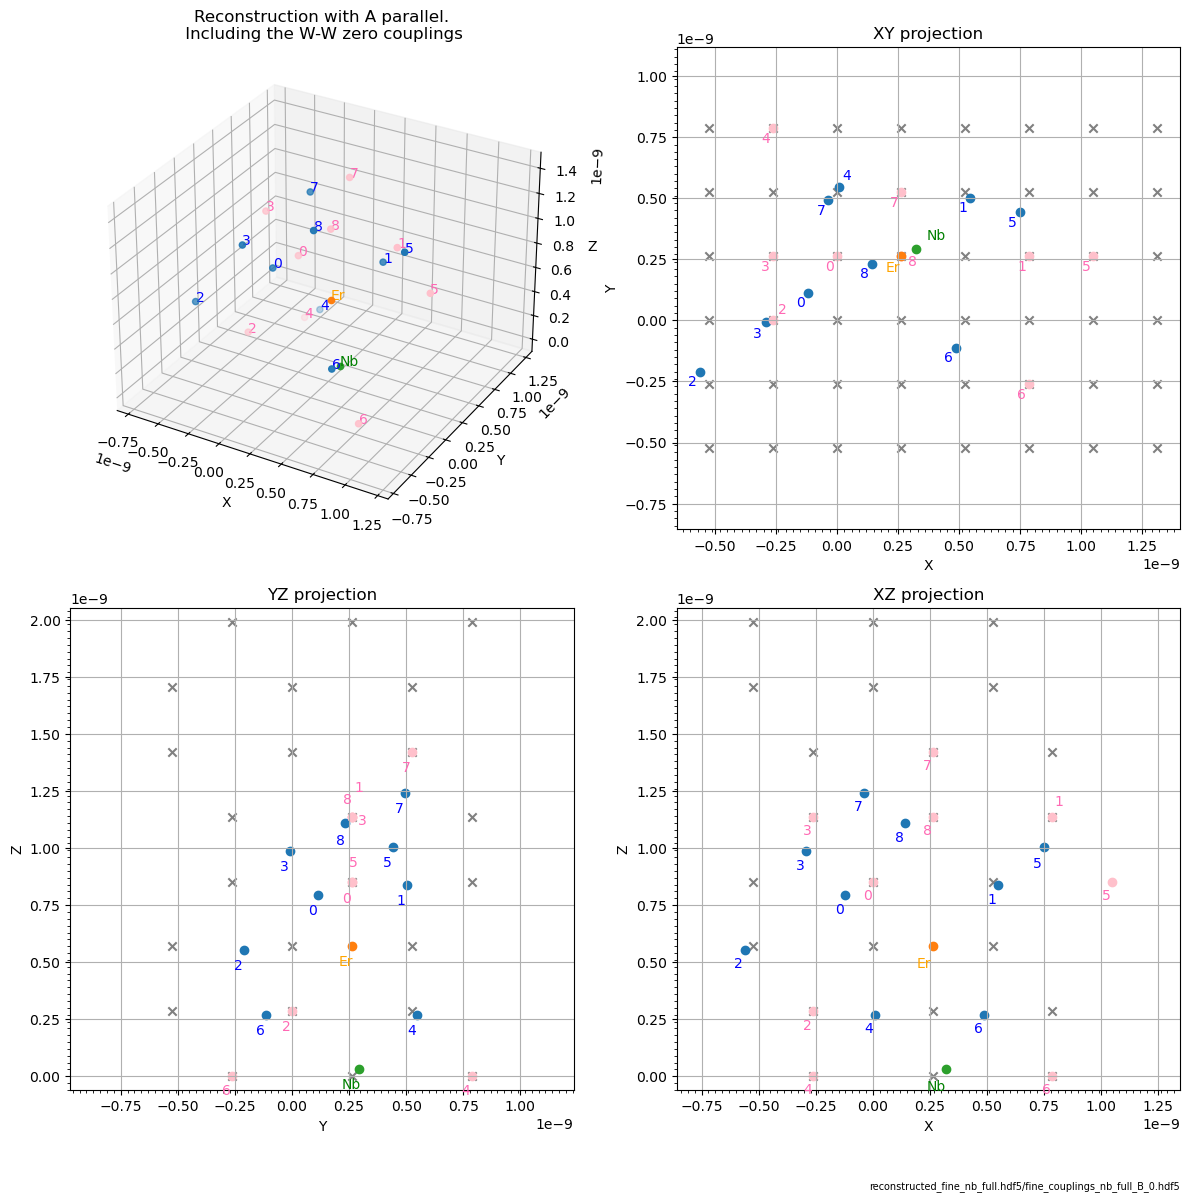

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1,projection='3d')
show_pink = True
ax.set_title(title)

ax.scatter(positions[:,0], positions[:,1], positions[:,2])
if show_pink: ax.scatter(base_positions[:,0], base_positions[:,1], base_positions[:,2], color="pink")

#ax.scatter(simplex[:,0], simplex[:,1], simplex[:,2], color = "black")

ax.scatter(0.5*a, 0.5*a, 0.5*c)
ax.scatter(0.5*a + nb_displacement[0], 0.5*a + nb_displacement[1], 0 + nb_displacement[2])
ax.text(0.5*a, 0.5*a, 0.5*c, "Er", color="orange")
ax.text(0.5*a + nb_displacement[0], 0.5*a + nb_displacement[1], 0 + nb_displacement[2], "Nb", color="green")


for i in range(len(positions)):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(selected_sites[i]), color="blue")

for i in range(len(base_positions)):
    if show_pink: ax.text(base_positions[i,0], base_positions[i,1], base_positions[i,2], str(i), color="hotpink")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')


ax = fig.add_subplot(2,2,2)
ax.set_title(f"XY projection")

for i in range(-1,3):
    for j in range(-1,2):
        ax.scatter(a*i + lattice_s[0,0], a*j + lattice_s[0,1], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[1,0], a*j + lattice_s[1,1], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[2,0], a*j + lattice_s[2,1], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[3,0], a*j + lattice_s[3,1], color='grey', marker="x")


ax.scatter(positions[:,0], positions[:,1])
if show_pink: ax.scatter(base_positions[:,0], base_positions[:,1], color="pink")

#ax.scatter(simplex[:,0], simplex[:,1], color = "black")

ax.scatter(0.5*a, 0.5*a)
ax.scatter(0.5*a + nb_displacement[0], 0.5*a + nb_displacement[1])

t = []
t.append(ax.text(0.5*a, 0.5*a, "Er", color="orange", ha='center', va='center'))
t.append(ax.text(0.5*a + nb_displacement[0], 0.5*a + nb_displacement[1], "Nb", color="green", ha='center', va='center'))


for i in range(len(positions)):
    t.append(ax.text(positions[i,0], positions[i,1], str(selected_sites[i]), color="blue", ha='center', va='center'))

for i in range(len(base_positions)):
    if show_pink: t.append(ax.text(base_positions[i,0], base_positions[i,1], str(i), color="hotpink", ha='center', va='center'))
adjust_text(t, expand=(1.5, 2), ax=ax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.grid()
ax.axis('equal')
pass



ax = fig.add_subplot(2,2,3)
ax.set_title(f"YZ projection")


for i in range(-1,2):
    for j in range(0,2):
        ax.scatter(a*i + lattice_s[0,1], c*j + lattice_s[0,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[1,1], c*j + lattice_s[1,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[2,1], c*j + lattice_s[2,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[3,1], c*j + lattice_s[3,2], color='grey', marker="x")

ax.scatter(positions[:,1], positions[:,2])
if show_pink: ax.scatter(base_positions[:,1], base_positions[:,2], color="pink")
#ax.scatter(simplex[:,1], simplex[:,2], color = "black")

ax.scatter(0.5*a, 0.5*c)
ax.scatter(0.5*a + nb_displacement[1], 0 + nb_displacement[2])

t = []
t.append(ax.text(0.5*a, 0.5*c, "Er", color="orange", ha='center', va='center'))
t.append(ax.text(0.5*a + nb_displacement[1], 0 + nb_displacement[2], "Nb", color="green", ha='center', va='center'))


for i in range(len(positions)):
    t.append(ax.text(positions[i,1], positions[i,2], str(selected_sites[i]), color="blue", ha='center', va='center'))

for i in range(len(base_positions)):
    if show_pink: t.append(ax.text(base_positions[i,1], base_positions[i,2], str(i), color="hotpink", ha='center', va='center'))

adjust_text(t, ax=ax, expand=(1.5, 2))

ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.grid()
ax.axis('equal')
pass



ax = fig.add_subplot(2,2,4)
ax.set_title(f"XZ projection")

for i in range(-1,2):
    for j in range(0,2):
        ax.scatter(a*i + lattice_s[0,0], c*j + lattice_s[0,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[1,0], c*j + lattice_s[1,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[2,0], c*j + lattice_s[2,2], color='grey', marker="x")
        ax.scatter(a*i + lattice_s[3,0], c*j + lattice_s[3,2], color='grey', marker="x")

ax.scatter(positions[:,0], positions[:,2])
if show_pink: ax.scatter(base_positions[:,0], base_positions[:,2], color="pink")
#ax.scatter(simplex[:,0], simplex[:,2], color = "black")

ax.scatter(0.5*a, 0.5*c)
ax.scatter(0.5*a + nb_displacement[0], 0 + nb_displacement[2])

t = []
t.append(ax.text(0.5*a, 0.5*c, "Er", color="orange", ha='center', va='center'))
t.append(ax.text(0.5*a + nb_displacement[0], 0 + nb_displacement[2], "Nb", color="green", ha='center', va='center'))
for i in range(len(positions)):
    t.append(ax.text(positions[i,0], positions[i,2], str(selected_sites[i]), color="blue", ha='center', va='center'))

if show_pink:
    for i in range(len(base_positions)):
        t.append(ax.text(base_positions[i,0], base_positions[i,2], str(i), color="hotpink", ha='center', va='center'))
adjust_text(t,expand=(1.5, 2), ax=ax)


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(step))
ax.grid()
ax.axis('equal')


ax.annotate(f'{file}/{couplings_file}',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=7)

fig.tight_layout()


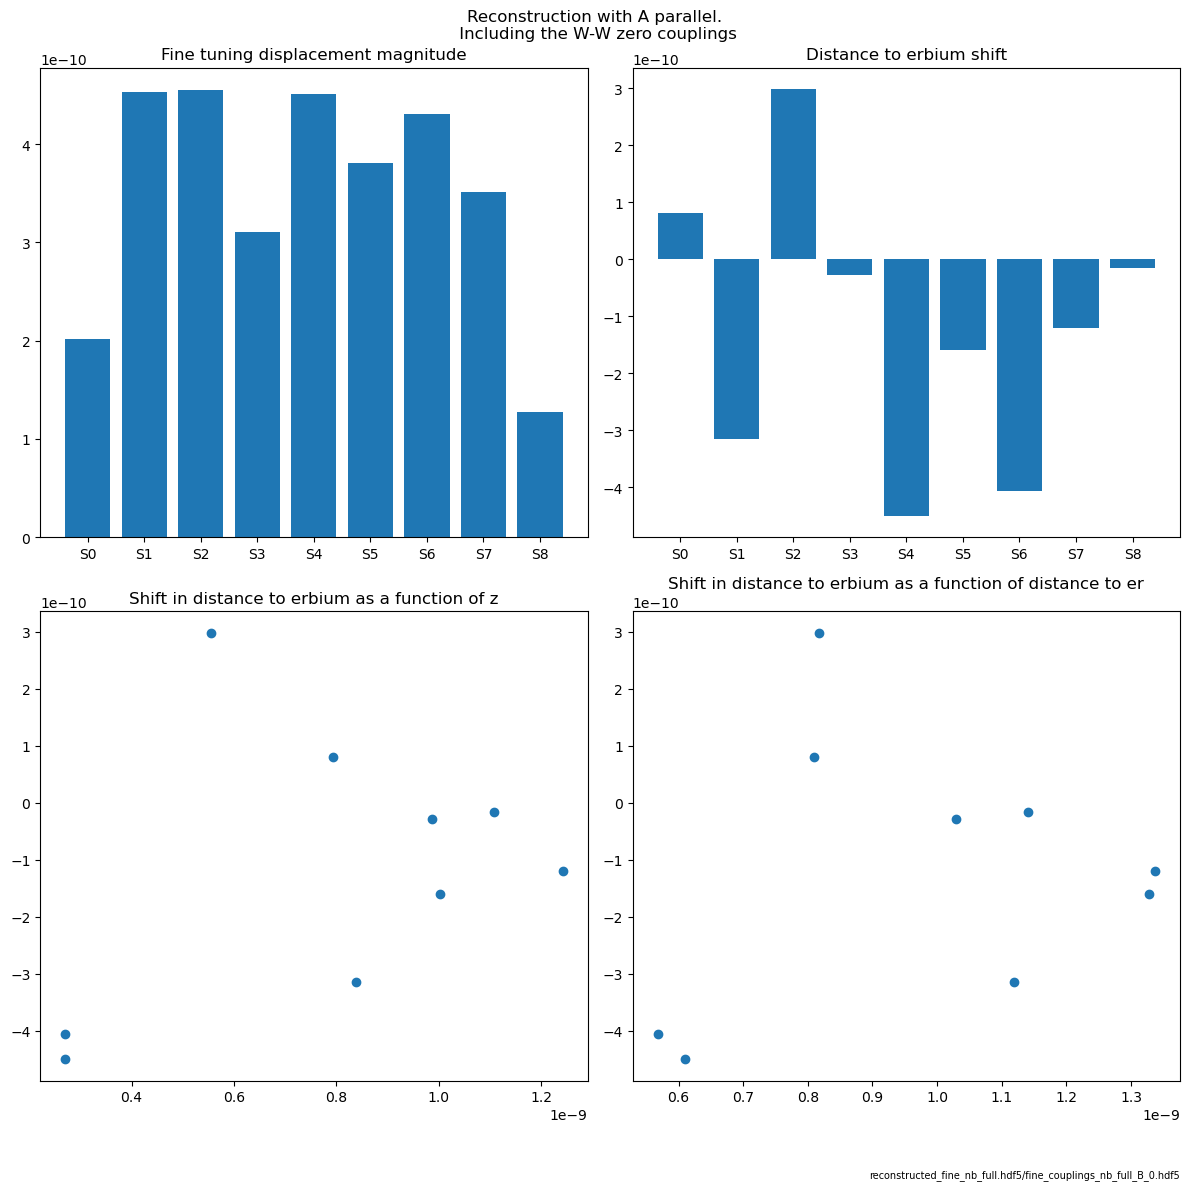

In [15]:
fig = plt.figure(figsize=(12,12))
fig.suptitle(title)
ax = fig.add_subplot(2,2,1)

labels = [f"S{i}" for i in selected_sites]

ax.set_title("Fine tuning displacement magnitude")

dr = positions - base_positions[selected_sites]

ax.bar(labels, np.linalg.norm(dr, axis=1))


ax = fig.add_subplot(2,2,2)

ax.set_title("Distance to erbium shift")

er_dist_shift = np.linalg.norm(positions - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis = 1) -  np.linalg.norm(base_positions[selected_sites] - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis=1)

ax.bar(labels, er_dist_shift)

ax = fig.add_subplot(2,2,3)

ax.set_title("Shift in distance to erbium as a function of z")

er_dist_shift = np.linalg.norm(positions - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis = 1) -  np.linalg.norm(base_positions[selected_sites] - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis=1)

ax.plot(positions[:,2], er_dist_shift, "o")

ax = fig.add_subplot(2,2,4)

ax.set_title("Shift in distance to erbium as a function of distance to er")

er_dist_shift = np.linalg.norm(positions - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis = 1) -  np.linalg.norm(base_positions[selected_sites] - np.array((0.5*a, 0.5*a, 0.5*c))[None,:], axis=1)

ax.plot(np.linalg.norm(positions, axis=1), er_dist_shift, "o")


ax.annotate(f'{file}/{couplings_file}',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=7)

fig.tight_layout()

### Comparing reconstructed data to real data

In [16]:
print(couplings.keys())

dict_keys([(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (0, 5), (1, 5), (2, 5), (3, 5), (0, 6), (2, 6), (0, 7), (1, 7), (2, 7), (3, 7), (0, 8), (1, 8), (2, 8), (3, 8)])


In [17]:
n = 0

config = all_displacements_index[n][permutation_inv]
reconstructed_couplings = np.full((len(a_par_data), len(a_par_data)), np.nan)
for i in range(len(a_par_data)):
    for j in range(i+1,len(a_par_data)):
        if i in selected_sites and j in selected_sites and not np.isnan(renormalized_data[i,j]):
            ri = np.where(selected_sites == i)[0]
            rj = np.where(selected_sites == j)[0]
            reconstructed_couplings[i,j] = couplings[(i, j)][config[ri],config[rj]].item()

reconstructed_a_par  = np.full(len(a_par_data), np.nan)
reconstructed_nb_par  = np.full(len(a_par_data), np.nan)
for i in range(len(a_par_data)):
    if i in selected_sites:
        ri = np.where(selected_sites == i)[0]
        reconstructed_a_par[i] = a_par[i][config[ri]].item()
        reconstructed_nb_par[i] = nb_par[i][config[ri], nb_displacements_index[0]].item()

In [18]:
def plot_comparison_table(meas, sim, cmap='summer', title='Measurement vs Simulation Comparison'):
    """
    Plots an NxN comparison table with a 2:1 figure aspect ratio.
    Cells with NaN in either measurement or simulation are left uncolored.

    Is this a better implem or the same ? => https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    """
    N = meas.shape[0]
    M = meas.shape[1]
    # Compute absolute discrepancies, ignoring NaNs for normalization
    diff = np.abs(meas - sim)
    norm = plt.Normalize(vmin=np.nanmin(diff), vmax=np.nanmax(diff))
    cmap = plt.get_cmap(cmap)
    
    # Create a wider figure: width = 2 * height
    fig, ax = plt.subplots(figsize=(2 * N*0.75+1, M*0.75+1))
    ax.set_xlim(0, N)
    ax.set_ylim(0, M)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(M+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.grid(False)
    
    for i in range(N):
            ax.text(i + 0.5, 0, f"S{i}",  va='bottom', ha='center', fontsize=10)
    for i in range(N):
        for j in range(min(i+1, M)):
            d = diff[i, j]
            # Skip coloring if NaN
            if np.isnan(d):
                cell_color = 'none'
            else:
                cell_color = cmap(norm(d))
            # Draw cell
            rect = plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black')
            ax.add_patch(rect)
            # Diagonal line
            ax.plot([i+1, i], [j, j+1], color='black', linewidth=1)
            # Text values (show 'nan' if NaN)
            meas_val = meas[i, j]
            sim_val = sim[i, j]
            txt_meas = f'{meas_val:.2f}' if not np.isnan(meas_val) else 'nan'
            txt_sim  = f'{sim_val:.2f}'  if not np.isnan(sim_val)  else 'nan'
            ax.text(i + 0.05, j + 0.15, txt_meas, va='top', ha='left', fontsize=10)
            ax.text(i + 0.95, j + 0.85, txt_sim,  va='bottom', ha='right', fontsize=10)
    
    # Colorbar (exclude NaNs)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(diff[~np.isnan(diff)])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Absolute discrepancy')
    
    ax.set_title(title,pad=20)
    
    ax.annotate(f'{file}/{couplings_file}',
                xy = (1.0, -0.2),
                xycoords='axes fraction',
                ha='right',
                va="center",
                fontsize=7)
    
    fig.tight_layout()
    plt.show()


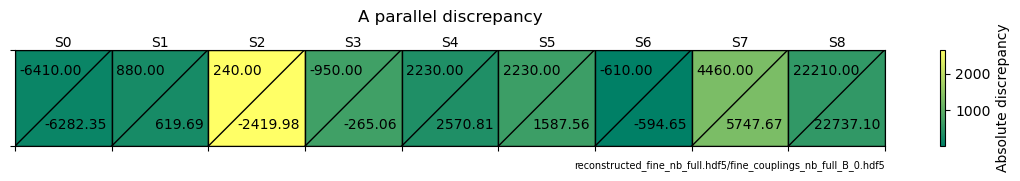

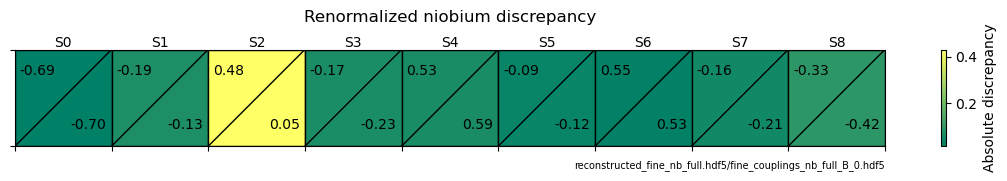

In [19]:

plot_comparison_table(-a_par_data[:,None],  -reconstructed_a_par[:,None], title="A parallel discrepancy")
plot_comparison_table(nb_par_data[:,None]*gamma_ratio, reconstructed_nb_par[:,None]*gamma_ratio, title="Renormalized niobium discrepancy")

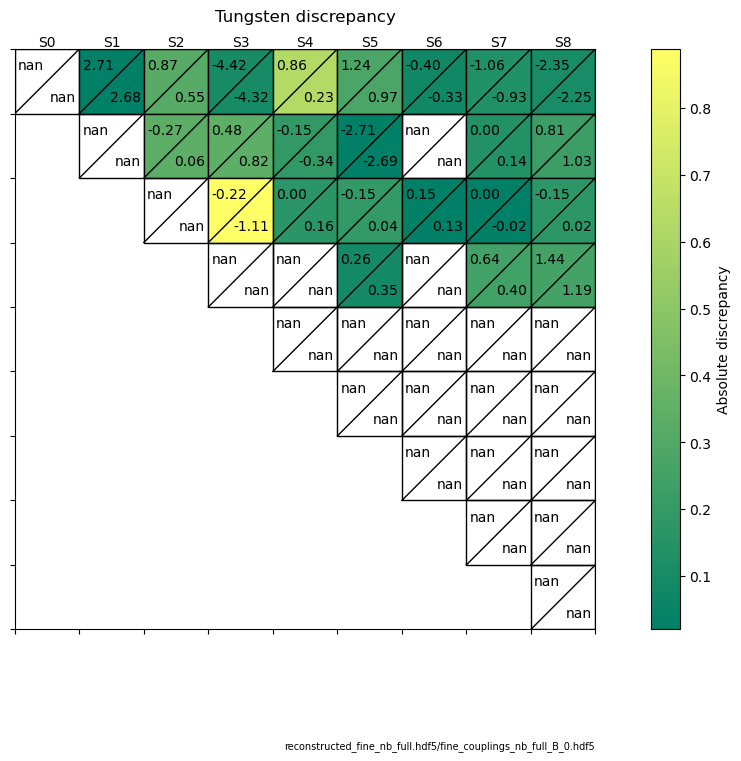

In [20]:
plot_comparison_table(renormalized_data.T, reconstructed_couplings.T, title="Tungsten discrepancy")

247

KeyboardInterrupt: 

0

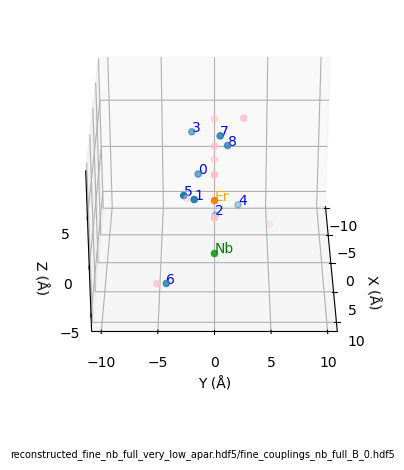

In [20]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_title(title)


base_positions_er = 1e10 * (base_positions - np.array([a/2, a/2, c/2]))
positions_er = 1e10 * (positions - np.array([a/2, a/2, c/2]))


atom = ax.scatter(positions_er[:,0], positions_er[:,1], positions_er[:,2])
atom_base = ax.scatter(base_positions_er[:,0], base_positions_er[:,1], base_positions_er[:,2], color="pink")


#ax.scatter(simplex[:,0], simplex[:,1], simplex[:,2], color = "black")


er = ax.scatter(0,0,0)
nb = ax.scatter(0,0,-0.5*c*1e10)
er_txt = ax.text(0, 0, 0, "Er", color="orange")
nb_txt = ax.text(0,0, -0.5*c*1e10, "Nb", color="green")


for i in range(len(positions)):
    ax.text(positions_er[i,0], positions_er[i,1], positions_er[i,2], str(selected_sites[i]), color="blue")

#for i in range(len(base_positions_er)):
#    ax.text(base_positions_er[i,0], base_positions_er[i,1], base_positions_er[i,2], str(i), color="hotpink")


ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')


ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.zaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.zaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_tick_params(length=1000)

ax.axis('equal')


ax.annotate(f'{file}/{couplings_file}',
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=7)

fig.tight_layout()


def animate(i):
    ax.view_init(azim=i)
    print(i, end = "\r")
    return (atom,atom_base, er, nb, er_txt, nb_txt)


ani = animation.FuncAnimation(fig, animate, repeat=True, frames=360, interval=50)
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('scatter.gif', writer=writer)